In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# import functions from the modsim library
from modsim import *

import math
import matplotlib.pyplot as plt
import queue

## Question

Our central goal is to model each element of getting lunch at Olin. Our question is a predictive one: If one enters the line at a given time, how long will they wait before sitting down with their food?

We have access to the total number of students as well as the overall class schedule. The class schedule tells us approximately how many students are busy or available throughout the lunch period, allowing us to predict their arrivals and departures.

## Model

Our model of getting lunch at Olin involves two queues. For clarity's sake, our first queue is that for the "Line" and the second for the "Food Court." The "Line" is the line to swipe one's card while the "Food Court" is where one waits to select their meal and then leave to the dining hall to sit down and eat. To populate the Line queue, we ran an exponentional distribution off of an arrival rate. This arrival rate was defined as the percentage of students available for lunch multipled by INSERT THING HERE. To find the number of available students, we did a breakdown of the class schedules. Using the number of students available over time created variation in time it takes each student to arrive. As students arrive, they are put into the queue (q) for the Line.

To determine how to populate q2 we have a swipe rate. This is how many people can move from the Line to the Food Court per minute. This swipe rate is currently arbitrarily decided, but after collecting data on Thursday, October 3rd, it will be based off of our collected average. When the dining hall is at the determined capacity, the Swipe function returns automatically, stopping the influx of students to the Food Court for that minute.

Once students are in q2, the "Food Court", they have a probability of leaving for each minute they are there. Once a student has left the Food Court, we stop counting their time.

Below are some resources we used to understand and guide our code:

learning about queues: 
https://dbader.org/blog/queues-in-python

could populate the queue with a for loop: 
https://www.geeksforgeeks.org/stack-queue-python-using-module-queue/

learning about exponential distribution: 
https://courses.lumenlearning.com/introstats1/chapter/the-exponential-distribution/

To model the lunch hour, we did a breakdown of the class schedule to find when students have time for lunch. Below is this year's class shedule, including only the parts of classes that have start or end times during the lunch period. Also, classes that meet at all of the same times are summed together into one bigger class.

We have created a class "person", as well as a System defining the total number of students that could have lunch in a given period, the maximum swipes per minute, and the total amount of time during the lunch period in minutes. 

Below, we define how the arrival time is calculated and define our "person" class. This class alows us to keep track of each person's time going through the Line and Food Court.

In [2]:
class person:
    def __init__(self, startTime):
        self.startTime = startTime
        self.swipeTime = 0
        self.exitTime = 0

In [3]:
sys = System(day=0, totalStudents=300, swipeRate=10, maxTime=150, maxInCourt=25, exitRate=4)
state = State(q = queue.Queue(maxsize=sys.totalStudents), q2 = queue.Queue(maxsize=sys.maxInCourt),
              q3 = queue.Queue(maxsize=sys.totalStudents), arrivalRate=0, arrivals=[0 for i in range(int(sys.maxTime))])

In [4]:
# Runs class schedule data compiling, summing up number of students in class at a
# given minute of the day based on each class' times and # students enrolled

class Duration:
    def __init__(self, hour, minute, hour2, minute2):
        self.startTime = (hour - 11.5) * 60 + minute
        self.endTime = (hour2 - 11.5) * 60 + minute2

class Class:
    def __init__(self, students, week):
        self.students = students
        self.week = week

def defineClasses():
    return [Class(11, {0:Duration(13,30,14,0)}), Class(9, {1:Duration(13,30,14,0)}),
               Class(26, {1:Duration(12,50,14,0)}), Class(6, {2:Duration(13,0,14,0)}),
               Class(86, {2:Duration(13,30,14,0)}),
               Class(123, {0:Duration(13,30,14,0), 3:Duration(13,30,14,0)}),
               Class(267, {0:Duration(11,30,12,30), 3:Duration(11,30,12,30)}),
               Class(24, {4:Duration(13,30,14,0)}),
               Class(22, {4:Duration(11,30,12,30)}),
               Class(23, {1:Duration(13,30,14,0)}),
               Class(22, {1:Duration(11,30,12,30)}),
               Class(99, {1:Duration(13,30,14,0), 4:Duration(13,30,14,0)}),
               Class(137, {1:Duration(11,30,12,30), 4:Duration(11,30,12,30)}),
               Class(16, {2:Duration(12,30,14,0), 4:Duration(13,30,14,0)})]

Determining how many students are in class:

In [5]:
def calcStudentsBusy(classes):
    # First # is day of the week beginning on Monday, second is minutes since lunch started
    studentsBusy = [[0 for i in range(int(sys.maxTime))] for j in range(5)]
    
    # for loop to sum up students in class on a given day at given time
    for c in classes:
        for day in c.week.keys():
            for t in range(len(studentsBusy[day])):
                if t >= c.week[day].startTime and t <= c.week[day].endTime:
                    studentsBusy[day][t] += c.students
    
    return studentsBusy

In [6]:
# Runs exponential distribution calculations of individuals' arrival times based on # people
# predicted to eat @ dining hall, students in class, and how many have already eaten lunch

def calcArrivalTimes(day):
    rate = 10
    state.arrivalRate = (sys.totalStudents - studentsBusy[day][0]) / sys.totalStudents * rate
    timestamp = np.random.exponential(scale=1.0/state.arrivalRate)
    state.arrivals[int(timestamp)] += 1
    prevTimestamp = 0
    
    becameBusy = 0
    alreadyAte = 1
    
    for i in range(1, int(sys.totalStudents)):
        # as students go back to class after eating lunch, there's significant overlap between students
        # already eaten and students busy, unlike how they were separate at the start of lunch.
        # to fix, the diff between prevNumStudentsBusy and currNumStudentsBusy is subtracted from
        # totalNumStudentsEaten, accumulating the integral of the positive overlap and subtracting it
        
        busyRightNow = studentsBusy[day][int(timestamp)]
        becameBusy += max([0, busyRightNow - studentsBusy[day][int(prevTimestamp)]])
        alreadyAte += 1 - becameBusy
        state.arrivalRate = ((sys.totalStudents - min([busyRightNow + alreadyAte, sys.totalStudents]))
                             / sys.totalStudents * rate)
        print(busyRightNow)
#         state.arrivalRate = ((sys.totalStudents - busyRightNow) / sys.totalStudents * rate)

        if state.arrivalRate > 0:
            prevTimestamp = timestamp
            timestamp += np.random.exponential(scale=1.0/state.arrivalRate)
            if timestamp >= sys.maxTime:
                return
            state.arrivals[int(timestamp)] += 1

The code below runs the simulation, updating who is arriving in Line, who gets swiped through to the Food Court, and who exits the system (equivalent to going into q3).

In [7]:
# Runs the dining hall line from the exponential distribution, finding how many people arrive in every minute and adding them to q.
def updateLine(minute):
    for p in range(state.arrivals[minute]):
        state.q.put(person(minute))

# If the size of q2 reaches that of the maximum Food Court size, then the funtion returns without swiping students through.
def updateSwipe(minute):
    for p in range(int(sys.swipeRate)):
        if state.q2.qsize() == sys.maxInCourt:
            return
        if not state.q.empty():
            human = state.q.get()
            human.swipeTime = minute
            state.q2.put(human)

# CHANGE ME!!! Approximately one fifth of the people in q2 leave every minute, making the average time spent getting food to be about 5 minutes. 
def updateExit(minute):
    for p in range(int(sys.exitRate)):
        if not state.q2.empty():
            human = state.q2.get()
            human.exitTime = minute
            state.q3.put(human)

In [8]:
# the arrays here append information in order to keep track of 
def runLineSimulation():
    timeSeries = []
    
    for minute in range(int(sys.maxTime)):
        lastIndex = updateLine(minute)
        updateSwipe(minute)
        updateExit(minute)
        timeSeries.append(state.q.qsize())
    
    return timeSeries

Defining how we would like to graph the final results of the model.

In [9]:
def determineResults():
    startTime = []
    timeDiff = []
    
    while not state.q3.empty():
        human = state.q3.get()
        startTime.append(human.startTime)
        timeDiff.append(human.exitTime - human.startTime)
#         print(human.startTime, human.swipeTime, human.exitTime)
    
    return startTime, timeDiff

## Results

Below you can find the graphs that the model creates.

First, a graph from the class schedules documenting the number of people in class on a given day and time. Then, the dining hall arrivals times - note the increase in people arriving at 12:45 - a phenomenon easily verified by the number of times we have waited in line then. Next up, the number of people in that line throughout the lunch period.

Our final graph shows how many people in a given minute leave the Food Court for the dining hall.

explain what this graph says about the model, three plots one for each day of the week plus overlap

reiterate the time thing



Text(0.5, 1.0, 'Class schedule')

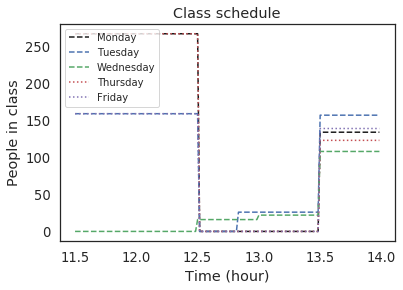

In [10]:
studentsBusy = calcStudentsBusy(defineClasses())

time = [11.5 + i/60 for i in range(150)]
plt.plot(time, studentsBusy[0], 'k--', label="Monday")
plt.plot(time, studentsBusy[1], 'b--', label="Tuesday")
plt.plot(time, studentsBusy[2], 'g--', label="Wednesday")
plt.plot(time, studentsBusy[3], 'r:', label="Thursday")
plt.plot(time, studentsBusy[4], 'm:', label="Friday")
plt.legend(loc='upper left', prop={'size': 10})
plt.ylabel('People in class')
plt.xlabel('Time (hour)')
plt.title('Class schedule')

[2, 0, 0, 0, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 2, 3, 1, 1, 3, 2, 3, 1, 2, 1, 2, 1, 2, 4, 3, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0, 3, 0, 1, 2, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 0, 0, 3, 11, 8, 16, 11, 7, 14, 13, 12, 16, 11, 7, 9, 9, 7, 10, 7, 6, 9, 8, 13, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Text(0.5, 1.0, 'Dining hall arrival times')

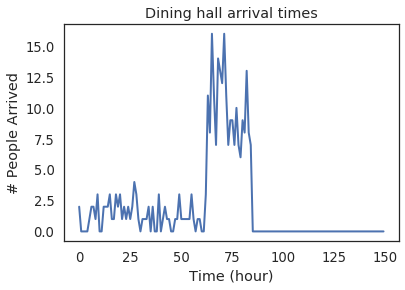

In [11]:
# adjust which day of the week to look at using the parameter there
calcArrivalTimes(0)
print(state.arrivals)
plot(state.arrivals)

plt.ylabel('# People Arrived')
plt.xlabel('Time (hour)')
plt.title('Dining hall arrival times')

Text(0.5, 1.0, 'Dining hall line length over time')

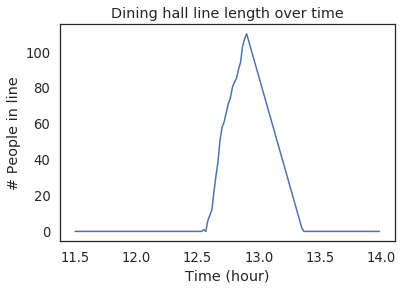

In [12]:
result = runLineSimulation()
plt.plot([11.5+i/60.0 for i in range(len(result))], result)
plt.ylabel('# People in line')
plt.xlabel('Time (hour)')
plt.title('Dining hall line length over time')

Text(0.5, 1.0, 'Wait time by arrival time')

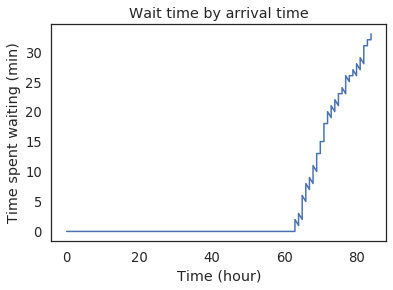

In [13]:
startTime, timeDiff = determineResults()
plt.plot(startTime, timeDiff)

plt.ylabel('Time spent waiting (min)')
plt.xlabel('Time (hour)')
plt.title('Wait time by arrival time')

## Interpretation

Our graphs currently show trends that seem reasonable compared to our experiences at the dining hall. However, this could be due to the assumptions we have made. Namely, the values for the max swipe rate, that the number of students eating is the total number of Olin students, and the max capacity of the Food Court. 

One of the largest things we are ommitting from the model is Taco Tuesday, and other themed lunch days that affect the number of students that come in. A higher percentage of Olin eats lunch on those days, and Babson students often come by as well. 

Much remains to be worked out for our model. First, we need to calculate the total time students are spending in the Line and Food Court based on how many times the simulation runs before they are moved to q3. We also need to take data and implement it to address the assumptions for the swipe rate etc. Finally, we need to implement the changing swipe rate based on the number of people in q2, the Food Court, to mimick what happens when there are so many people that the line stops moving for a minute or so. 

In the end, it would be nice to have a graph that plots wait time as a function of arrival time. There could be 5 of these graphs, one for each day of the school week. In the days to come we are pushing towards these goals and minimizing our assumptions.

External validation? look into other models (ex dinner rush at a big restaurant)...